# Simulating True Market Variability

The idea here is to compare Ecoinvent market simulation runs to the individual supplier production processes to show that, given basic uncertainty about the specific process used to create a product, the market far underestimates uncertainty in the impact of the production.  

This is caused by an epistemic error implicit in Ecoinvent's market implementation.  If there is basic uncertainty about the specific supplier or technology from which a technosphere input is drawn, the Ecoinvent approach is to assume that the input is a market-weighted average of all known suppliers.  However, this is not appropriate; rather, the prior assumption should be that a given input is _drawn_ from the global market from a _particular_ supplier whose identity is not known. 

As the results below demonstrate, taking the first approach (even with repeated samples) results in a probability distribution that is _guaranteed_ to be narrower than the actual variability in the market, at times catastrophically.  In contrast, selecting one particular supplier for each monte carlo run, on the basis of market share, provides a much more accurate picture of this inherent variability.

This demonstration undermines the suggestions, found in recent emerging research, that the probability distributions of aggregate LCI datasets follow a lognormal distribution and that they can be easily parameterized. It also generally contradicts the prevailing strategy for interpreting Monte Carlo analyses based on Ecoinvent.


In [1]:
import sys
import re
import time
from antelope_catalog import LcCatalog
STUDY_PATH = '/data/GitHub/2018/variability_jlca/'
DATA_PATH = '/data/GitHub/python-work/lca-tools/Case Studies/Ecoinvent Variability'

sys.path.append(STUDY_PATH)

cat = LcCatalog(STUDY_PATH + 'catalog', quell_biogenic_co2=True)

Loading JSON data from /data/GitHub/lca-tools/lcatools/qdb/data/flowable_synlist.json:
Loading JSON data from /data/GitHub/lca-tools/lcatools/qdb/data/quantity_synlist.json:
local.qdb: /data/GitHub/2018/variability_jlca/catalog/reference-quantities.json
Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/reference-quantities.json:
local.qdb: /data/GitHub/lca-tools/lcatools/providers/data/elcd_reference_quantities.json
24 new quantity entities added (24 total)
5 new flow entities added (5 total)


In [2]:
cat.show_interfaces()

local.ecoinvent.3.4.apos [basic, index, inventory]
local.ecoinvent.3.4.apos.index__20180905 [background, basic, index]
local.ecoinvent.3.4.conseq [basic, index, inventory]
local.ecoinvent.3.4.cutoff [basic, index, inventory]
local.ecoinvent.3.4.cutoff.index__20180905 [background, basic, index]
local.lcia.ecoinvent.3.1.2014_08_13 [basic, index, quantity]
local.qdb [basic, index, quantity]


In [3]:
recipe_methods = [('ReCiPe Midpoint (H)', 'climate change', 'GWP100'),
                  ('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'),
                  ('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'),
                  ('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP')
                 ]

# unfortunately slow the first time
qs = [cat.query('local.lcia.ecoinvent.3.1.2014_08_13').get(', '.join(rm)) for rm in recipe_methods]


local.lcia.ecoinvent.3.1.2014_08_13: /data/LCI/Ecoinvent/LCIA/LCIA implementation v3.1 2014_08_13.xlsx
Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/cache/cfa3982d248fbdf0224e3ebad316063c182bbbbd.json.gz:
local.lcia.ecoinvent.3.1.2014_08_13: /data/GitHub/2018/variability_jlca/catalog/cache/cfa3982d248fbdf0224e3ebad316063c182bbbbd.json.gz
704 new quantity entities added (704 total)
3255 new flow entities added (3255 total)


In [5]:
# optional 
#cat.create_source_cache(cat.get_resource('local.lcia.ecoinvent', strict=False).source, static=True)

In [6]:
from lca_variability import initialize_activity, initialize_market_model

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
from lca_variability import MarketIterator

In [10]:
qa = cat.query('local.ecoinvent.3.4.apos')
mi_apos = MarketIterator(qa, *qs)

In [16]:
qc = cat.query('local.ecoinvent.3.4.cutoff')
mi_cutoff = MarketIterator(qc, *qs)

In [12]:
from math import ceil
import time
import numpy as np

In [13]:
class TraceLine(object):
    def __init__(self, value, label=None, **kwargs):
        self.value = value
        self._label = label
        self._args = kwargs
        
    @property
    def label(self):
        if self._label is None:
            return 'TraceLine(%g)' % self.value
        return self._label
    
    @property
    def args(self):
        return self._args

In [74]:
from numpy import logspace, log10

In [223]:
def _find_range(ax, dat):
    r1 = 1.2 * (max(dat) - min(dat))
    r2 = ax.get_xlim()[1] - ax.get_xlim()[0]
    return max([r1, r2])

def _kill_zeros(data, factor=10):
    _zero = data == 0
    if sum(_zero) > 0:
        low = next(k for k in sorted(data) if k > 0) / factor
        print('Warning: %d zero-valued scores found. Replacing with 1/%d the lowest nonzero value..' % 
              (sum(_zero), factor))
        data[_zero] = low
    return data


def _add_mc_hist_to_ax(_ax, _data, bins=50, density=False, show_ci=False, log_correct=False, log_scale=True, **kwargs):
    _npres = np.array(_data)
    if log_scale:
        _npres = _kill_zeros(_npres)

    _trim = is_outlier(_npres, thresh=6)
    _nptrim = _npres[~_trim]
    if show_ci:
        _tag = ' (w/95CI)'
    else:
        _tag = ''
                
    if log_correct:
        log_bins = logspace(log10(min(_nptrim)) - .001, log10(max(_nptrim)), bins+1)
        vv, bins, _ = plt.hist(_nptrim, bins=log_bins, axes=_ax, histtype='step', density=False, 
                               linestyle=':', linewidth=2,
                               label='Monte Carlo N=%d%s' % (len(_data), _tag))
    else:
        vv, bins, _ = plt.hist(_nptrim, bins=bins, axes=_ax, histtype='step', density=density, 
                               linestyle=':', linewidth=2,
                               label='Monte Carlo N=%d%s' % (len(_data), _tag))
    if log_scale:
        _ax.set_xscale('log')
    
    if show_ci:
        _bounds = find_95(_nptrim)
        _ylim = _ax.get_ylim()
        _yval = 0.82 * _ylim[0] + 0.18 * _ylim[1]
        if show_ci == 'stem':
            _m, _s, _b = plt.stem(_bounds, (_yval, _yval))
            plt.setp(_m, color=[0.7, 0, 0.4], marker='+', markersize=8, markeredgewidth=2)
            plt.setp(_b, visible=False)
            plt.setp(_s, color=[0.7, 0, 0.4])
        else:
            plt.scatter(_bounds, (_yval, _yval), marker='|', s=500, c=[[0.7, 0, 0.4]])
        
    return vv, bins, _npres[_trim]

def _add_discrete_bars_to_ax(_ax, _xv, _yv, _norm, _nbins=50, _color=[0.7, 0, 0], **kwargs):
    rang = _find_range(_ax, _xv)
    _wid = rang / _nbins
    # _wid = max(_yv) / _norm
    plt.bar(_xv, [_k / _wid for _k in _yv], width=_wid, color=_color, axes=_ax, **kwargs)

def _add_scaled_bars_to_ax(_ax, _xv, _yv, _scale, _nbins=50, _color=[0, 0.4, 0.3], **kwargs):
    rang = _find_range(_ax, _xv)
    _wid = rang / _nbins
    plt.bar(_xv, [_i * _scale for _i in _yv], width=_wid, color=_color, axes=_ax, **kwargs)
    
_marker_props = ('marker', 'markersize', 'markerfacecolor', 'markeredgecolor', 'markeredgewidth')
_stem_props = ('linewidth', 'linestyle')
    
def _add_stem_plot_to_ax(_ax, _xv, _yv, _scale, _color=[0, 0.62, 0.08], label=None, **kwargs):
    (mkrs, stems, baseline) = plt.stem(_xv, [_i * _scale for _i in _yv], label=label)
    plt.setp(baseline, visible=False)
    plt.setp(stems, color=_color, **{k: v for k, v in kwargs.items() if k in _stem_props})
    _mkr_set = {k: v for k, v in kwargs.items() if k in _marker_props}
    if len(_mkr_set) > 0:
        plt.setp(mkrs, **_mkr_set)
    
def mc_mkt_combo(ax, xvals, shares, mc_res, annot, style='stem', traces=None, **kwargs):
    """
    valid styles: 'norm', 'stem', 'scaled'
    """
    if style not in ('norm', 'stem', 'scaled'):
        raise ValueError('unknown style %s' % style)

    opt = style == 'norm'
    vv, bins, trimmed = _add_mc_hist_to_ax(ax, mc_res, density=opt, **kwargs)
    if len(trimmed) > 0:
        print('%s: Trimmed %d outliers' % (annot['method'], len(trimmed)))

    '''
    _npres = np.array(mc_res)
    _trim = is_outlier(_npres, thresh=6)
    if sum(_trim) > 0:
        print('%s: Trimming %d outliers' % (annot['method'], sum(_trim)))
        
    vv, bins, _ = plt.hist(_npres[~_trim], bins=50, axes=ax, histtype='step', density=opt, linestyle=':', linewidth=2,
                          label='Monte Carlo N=%d' % len(mc_res))
    '''
    if ax.get_xscale() == 'log':
        xvals = [bins[0] if x == 0 else x for x in xvals]
    if opt:
        _add_discrete_bars_to_ax(ax, xvals, shares, max(vv), label='suppliers') 
        #, _color='none', linestyle='--', linewidth=0.8, edgecolor='black')
        ax.set_yticks([])
        ax.set_ylabel('Relative Frequency')
    else:
        mxsh = max(vv) / max(shares)
        if style == 'scaled':
            _add_scaled_bars_to_ax(ax, xvals, shares, mxsh, _nbins=65)
        else:
            _add_stem_plot_to_ax(ax, xvals, shares, mxsh, label='suppliers (%s)' % annot['ei'])
        # ax.yaxis.tick_right()
        ax.set_ylabel('Market Share')
        
        mxlb = ceil(max(shares) * 10)
        lbl_vals = [x/10 for x in range(mxlb)]
        lbl_pos = [x * mxsh for x in lbl_vals]
        lbl_name = ['%.1f' % x for x in lbl_vals]
        
        ax.set_yticks(lbl_pos)
        ax.set_yticklabels(lbl_name)
    
    ax.set_title(annot['title'])
    ax.set_xlabel(annot['method'])
    if traces is not None:
        ylim = ax.get_ylim()
        for tr in traces:
            ax.vlines(tr.value, ylim[0], ylim[1], label=tr.label, **tr.args)
        ax.set_ylim(ylim)



In [25]:
from math import ceil, floor
def find_95(_data):
    _l = len(_data)
    _s = sorted(_data)
    _i025 = _s[ceil(_l * 0.025)]
    _i975 = _s[floor(_l * 0.975)]
    return _i025, _i975


def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

## Generate Example Figures for Part 2

In [229]:
# application functions

db_map = {'local.ecoinvent.3.4.apos': ('ei3.4 apos', mi_apos),
          'local.ecoinvent.3.4.cutoff': ('ei3.4 cutoff', mi_cutoff)}

def generate_runs_by_id(origin, mkt_ref, steps=1200):
    _ts = time.time()
    _dbs = db_map[origin]
    print('=== time %.3f ===' % (time.time() - _ts))
    _mkt_study = _dbs[1].get_result(mkt_ref)
    print('=== time %.3f ===' % (time.time() - _ts))
    _mca = initialize_activity(_dbs[0], mkt_ref, *recipe_methods, steps=steps)
    print('=== time %.3f ===' % (time.time() - _ts))
    return _mkt_study, _mca


def _market_name(market):
    name = re.sub('Europe without Switzerland', 'EU excl. CH', market._name)
    return name


def _plot_mkt_run(_ax, _study, _mca, index=0, style='stem', annot=None, traces=None, **kwargs):
    if annot is None:
        annot = {'title': _market_name(_study.market),
                 'method': '%s: %s [%s]' % recipe_methods[index],
                 'ei': db_map[_study.market.origin][0]
                }
    tr=[TraceLine(_study.market_scores[index], label='Market average')]
    if traces is not None:
        tr.extend(traces)
        
    # ts traces
    if _study.market.external_ref == M_GLY:
        if recipe_methods[index] in ts_data:
            data = ts_data[recipe_methods[index]]
            styles = ts_data['linestyles']
            for i, p in enumerate(ts_data['processes']):
                tr.append(TraceLine(data[i], label=p, **styles[i]))
    
    mc_mkt_combo(_ax, _study.scores(qs[index]), _study.exchange_values, _mca.scores(recipe_methods[index]),
                annot=annot, style=style, traces=tr, **kwargs)
    
def plot_mkt_run(_study, _mca, index=0, **kwargs):
    if isinstance(index, int):
        ax = plt.axes()
        _plot_mkt_run(ax, _study, _mca, index=index, **kwargs)
        return ax
        
    else:
        _axs = []
        annot = {'title': _market_name(_study.market),
                'ei': db_map[_study.market.origin][0].upper()}
        l = len(index)
        if l == 4:
            fig = plt.figure(figsize=(12, 8))
        else:
            fig = plt.figure(figsize=(8, 4 * l))
        for i, v in enumerate(index):
            annot['method'] = recipe_methods[v]
            if l == 4:
                _axs.append(fig.add_subplot(2, 2, i+1))
            else:
                _axs.append(fig.add_subplot(l, 1, i+1))
            _plot_mkt_run(_axs[-1], _study, _mca, index=v, annot=annot, **kwargs)
            
            annot['title'] = ''
        _axs[0].legend()
        return _axs
        
def generate_mkt_runs_by_id(origin, mkt_ref, steps=1200, do_activity=True, do_market=False):
    _ts = time.time()
    _dbs = db_map[origin]
    print('=== time %.3f ===' % (time.time() - _ts))
    _mkt_study = _dbs[1].get_result(mkt_ref)
    print('=== time %.3f ===' % (time.time() - _ts))
    if do_activity:
        _mca = initialize_activity(_dbs[0], mkt_ref, *recipe_methods, steps=steps)
        print('=== time %.3f ===' % (time.time() - _ts))
    else:
         _mca = None
    if do_market:
        _mca_mkt = initialize_market_model('ei3.4 cutoff', _a.activity.get('activity'), *recipe_methods, steps=500)
        print('=== time %.3f ===' % (time.time() - _ts))
    else:
        _mca_mkt = None
    return _mkt_study, _mca, _mca_mkt


In [233]:
## cutoffs
origin = 'local.ecoinvent.3.4.cutoff'

### Large markets n>10
ext_id, plot_name = '45590532-cfd4-46a9-abb5-209e0d998f83', 'm4h-d-i-nng_EwS_ei34_cutoff-5k'  # district heat not from natural gas, Europe ex CH ## CONTENDER
# ext_id = '64fb9db2-cb2e-4078-b6cb-1b5f38e02f45'  # market for copper
# ext_id = '7533e0cf-bdcd-4ac0-8690-208f08f0428a'  # market for N fertilizer

### spread-out markets
# ext_id = '0deab922-a352-40d3-b114-3b5c8dfcb83d'  # diethyl ether
# ext_id, plot_name = '2846e11e-2102-48a5-baa3-7782b43d914d', 'v-o-m-e_34_cutoff'  # vegetable oil methyl ester ## WINNER
#ext_id = '3eab55e6-a0fc-48cd-b5c0-a1c090646191'  # HCN


_s, _a, _ma = generate_mkt_runs_by_id(origin, ext_id, steps=500, do_activity=True, do_market=True)
# _a.steps = 500

=== time 0.000 ===
=== time 0.000 ===
Loading JSON data from /data/GitHub/python-work/lca-tools/Case Studies/Ecoinvent Variability/BW2_MCA_45590532-cfd4-46a9-abb5-209e0d998f83.json.gz:
Up to date with 5000 samples, 4 methods
=== time 3.095 ===
Loading JSON data from /data/GitHub/python-work/lca-tools/Case Studies/Ecoinvent Variability/BW2_MktWt_45590532-cfd4-46a9-abb5-209e0d998f83.json.gz:
Up to date with 1250 samples, 4 methods
=== time 5.425 ===


In [235]:
import re

Up to date with 5000 samples, 4 methods
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): Trimmed 76 outliers
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): Trimmed 6 outliers


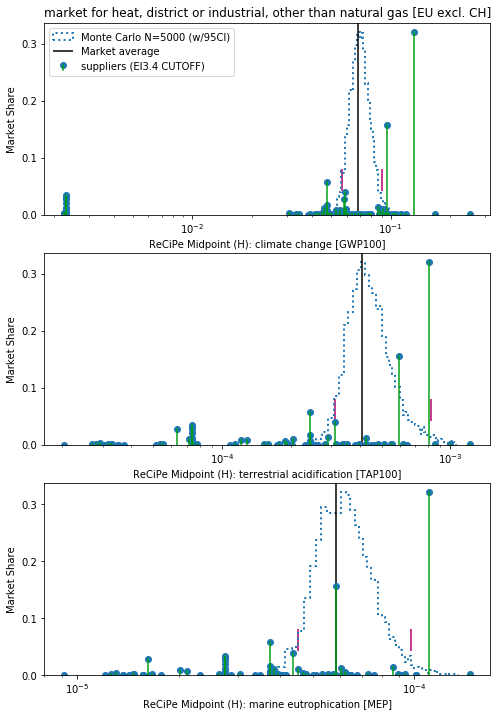

In [240]:
# Market average simulation
_a.steps = 1250
axs = plot_mkt_run(_s, _a, index=(0, 1, 3), show_ci=True)
plt.savefig('%s-average-log.eps' % plot_name, format='eps', bbox_inches='tight', transparent=True)

Up to date with 1250 samples, 4 methods
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): Trimmed 2 outliers
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): Trimmed 2 outliers


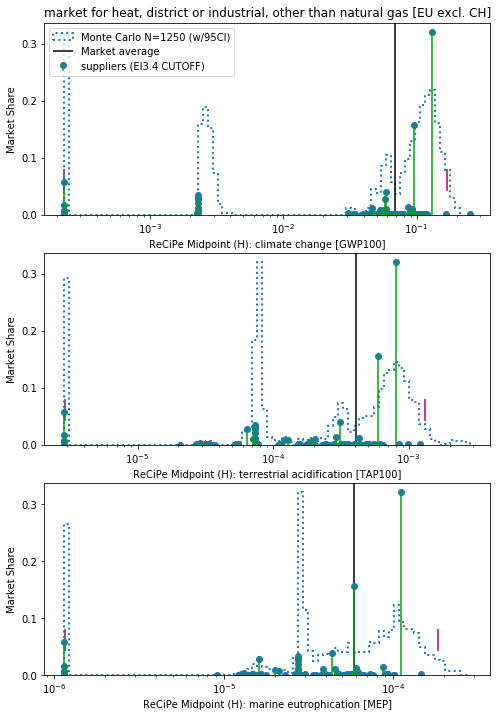

In [238]:
# Market-weighted simulation
_ma.steps = 1250
axs = plot_mkt_run(_s, _ma, index=(0, 1, 3), show_ci=True, log_correct=True, bins=80)
plt.savefig('%s-mktweight-log.eps' % plot_name, format='eps', bbox_inches='tight', transparent=True)

In [43]:
_a.steps = 1000

Completed 100 MCA samples (47.783 sec)
Completed 200 MCA samples (96.016 sec)
Completed 300 MCA samples (144.737 sec)
Completed 400 MCA samples (193.431 sec)
Completed 500 MCA samples (243.965 sec)
Up to date with 1000 samples, 4 methods
Added 2000 results from 500 MCA samples (243.965 sec)
Written to /data/GitHub/python-work/lca-tools/Case Studies/Ecoinvent Variability/BW2_MCA_2846e11e-2102-48a5-baa3-7782b43d914d.json.gz


Up to date with 5000 samples, 4 methods
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): Trimmed 76 outliers
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): Trimmed 6 outliers


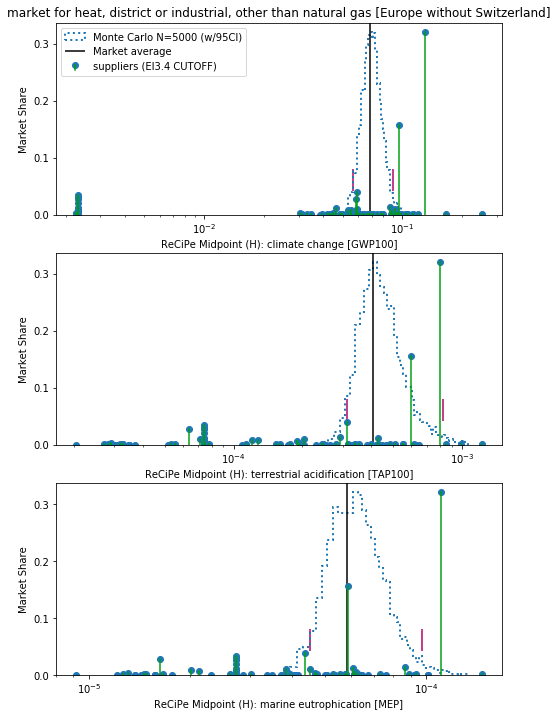

In [110]:
_a.steps = 1250
axs = plot_mkt_run(_s, _a, index=(0, 1, 3), show_ci=True)

#plt.savefig(plot_name, format='eps', bbox_inches='tight', transparent=True)

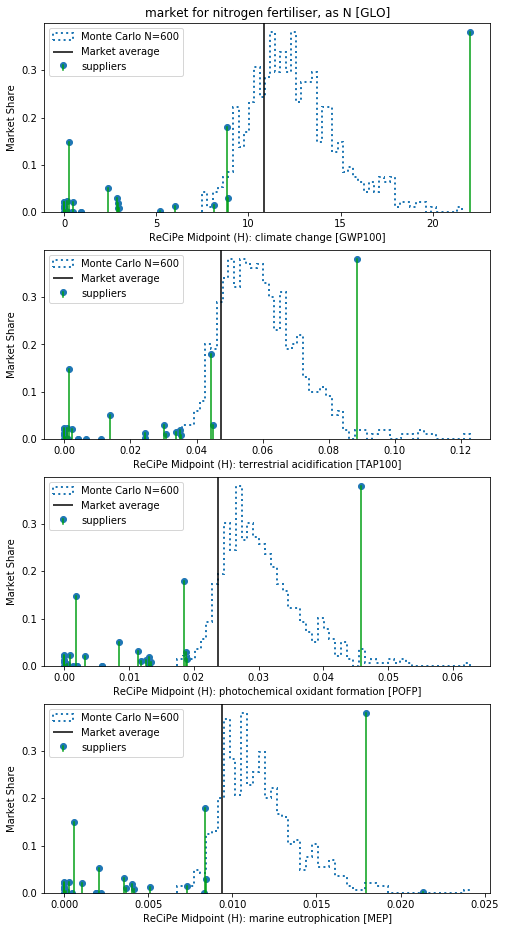

In [137]:
# another contender...
plot_mkt_run(_s_n, _a, index=(0, 1, 2, 3))

# Glycerine Example
This one was ultimately abandoned as subideal in favor of the vegetable oil methyl ester.

In [4]:
M_GLY = '4d024c87-fcab-4980-9347-c3bee224671f'

# from spreadsheet from Liila Woods 2019-01-10
ts_data = {
    'processes': ['DE: Glycerine (from Epichlor.) ts',
                  'DE: Glycerine from RME ($ alloc) ts'],
    'linestyles': [
        {
            'linestyle': ':',
            'color': [1, 0, 0]
        },
        {
            'linestyle': '-.',
            'color': [0, 0, 1]
        }
    ],
    recipe_methods[0]: [8.23562061020724, 0.514477097381447],
    recipe_methods[1]: [0.007426994525449, 0.007520819864429],
    recipe_methods[3]: [0.000184808227556, 0.001475900547191]
}

In [11]:
a_gly = mi_apos.get_result(M_GLY)

Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/index/a57075ecd68e35920696904ec830bc522fc6b2b2.json.gz:
local.ecoinvent.3.4.apos.index__20180905: /data/GitHub/2018/variability_jlca/catalog/index/a57075ecd68e35920696904ec830bc522fc6b2b2.json.gz
local.ecoinvent.3.4.apos: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_apos_ecoSpold02
local.ecoinvent.3.4.apos.index__20180905: /data/GitHub/2018/bw2-uncertainty/catalog/index/a57075ecd68e35920696904ec830bc522fc6b2b2.json.gz
13290 new process entities added (13290 total)
19 new quantity entities added (19 total)
4851 new flow entities added (4851 total)
local.ecoinvent.3.4.apos: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_apos_ecoSpold02
local.ecoinvent.3.4.apos.index__20180905: /data/GitHub/2018/variability_jlca/catalog/archives/local.ecoinvent.3.4.apos.index__20180905_background.mat
Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/archives/local.ecoinvent.3.4.apos.index__20180905_background.mat.index.json.gz:
completed 65

In [23]:
# a = Bw2McaContainer.from_file(os.path.join(DATA_PATH, 'BW2_MCA_%s_.json.gz' % M_GLY)
a = initialize_activity('ei3.4 apos', M_GLY, *recipe_methods)

Loading JSON data from /data/GitHub/python-work/lca-tools/Case Studies/Ecoinvent Variability/BW2_MCA_4d024c87-fcab-4980-9347-c3bee224671f.json.gz:
Up to date with 5000 samples, 4 methods


('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): Trimmed 1 outliers


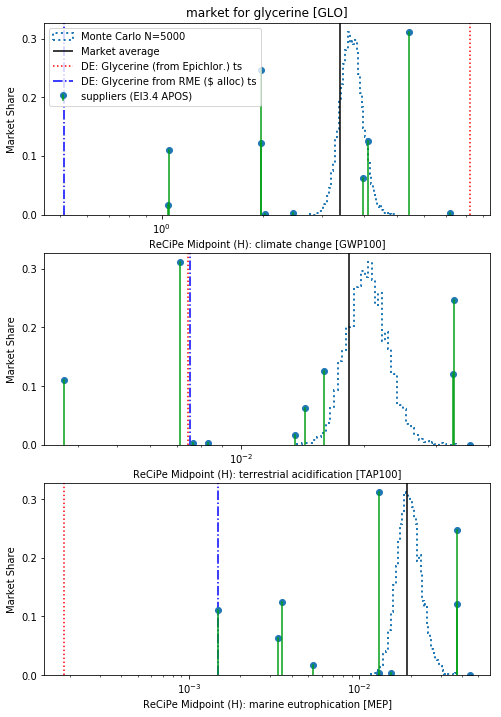

In [107]:
plot_mkt_run(a_gly, a, index=(0, 1, 3))

In [41]:
a.filename

'BW2_MCA_4d024c87-fcab-4980-9347-c3bee224671f.json.gz'

In [43]:
a_gly.market.link

'local.ecoinvent.3.4.apos/4d024c87-fcab-4980-9347-c3bee224671f'

In [28]:
f = initialize_market_model('ei3.4 apos', M_GLY, *recipe_methods)

In [34]:
f.steps = 1000

Completed 100 MCA samples (55.569 sec)
Completed 200 MCA samples (117.770 sec)
Completed 300 MCA samples (174.262 sec)
Completed 400 MCA samples (235.752 sec)
Completed 500 MCA samples (293.670 sec)
Completed 600 MCA samples (352.371 sec)
Completed 700 MCA samples (415.255 sec)
Completed 800 MCA samples (471.445 sec)
Completed 900 MCA samples (539.067 sec)
Up to date with 1000 samples, 4 methods
Added 3600 results from 900 MCA samples (539.067 sec)
Written to /data/GitHub/python-work/lca-tools/Case Studies/Ecoinvent Variability/BW2_MktWt_4d024c87-fcab-4980-9347-c3bee224671f.json.gz


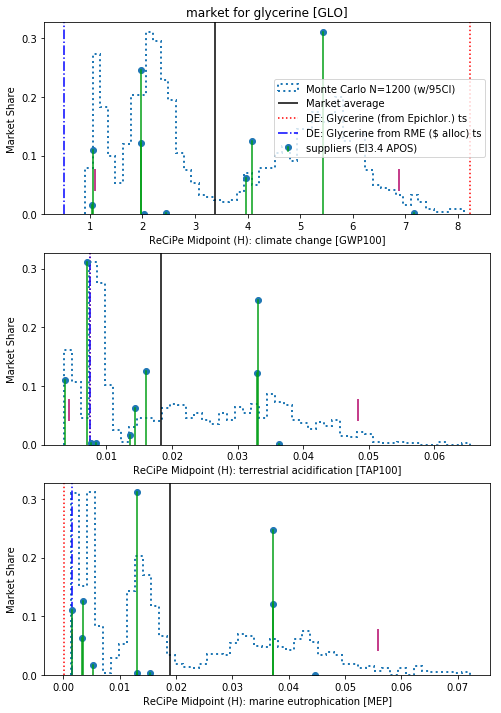

In [43]:
#f.steps = 5000
plot_mkt_run(a_gly, f, index=(0, 1, 3), show_ci=True)

## Validate off-center Distribution
It is observed that the BW2 monte carlo simulation for M_GLY is not centered on the market average for GWP, which is surprising.  So we want to make sure we didn't make any mistakes by checking two things:
 1. Confirming that the BW2 point-source solution equals the Antelope point-source solution
 2. Confirming that the BW2 stock MCA result is not centered around the BW2 point source solution

In [36]:
from brightway2 import LCA

In [38]:
lca = LCA({a.activity: 1}, method=recipe_methods[0])

#### First, compare point-source results

In [51]:
lca.switch_method(recipe_methods[0])
lca.lci()
lca.lcia()
print('BW2 result: %.10g' % lca.score)
print('Antelope:   %.10g' % a_gly.market_scores[0])

BW2 result: 3.385347575
Antelope:   3.385347479


In [50]:
lca.switch_method(recipe_methods[1])
lca.lcia()
print('BW2 result: %.10g' % lca.score)
print('Antelope:   %.10g' % a_gly.market_scores[1])

BW2 result: 0.01832687829
Antelope:   0.01832687671


#### Now check the BW2 native MCA solution

In [43]:
from brightway2 import MonteCarloLCA

In [44]:
mca = MonteCarloLCA({a.activity : 1}, method=recipe_methods[1])

In [45]:
res_mca = [next(mca) for x in range(300)]

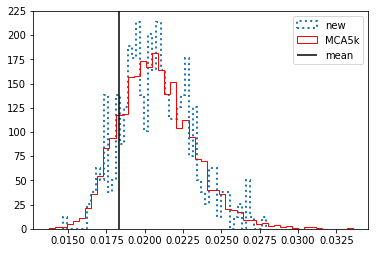

In [46]:
ax = plt.axes()
_ = plt.hist(res_mca, bins=50, density=True, axes=ax, histtype='step', linestyle=':', linewidth=2, label='new')
_ = plt.hist(a.scores(mca.method), bins=50, density=True, axes=ax, histtype='step', color=[1, 0, 0], 
             linestyle='-', linewidth=1, label='MCA5k')
yl = ax.get_ylim()
ax.vlines(lca.score, *yl, label='mean')
ax.set_ylim(yl)
ax.legend()

So that looks good too. So the monte carlo distribution just skews high for this process for "some reason"